# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import time 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor


In [2]:
df=pd.read_csv('/datasets/autos.csv')

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
#меняем регистр названий столбцов
new_columns = df.columns.str.lower()
df.set_axis(new_columns, axis = 'columns', inplace = True)

In [5]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Цена'}, xlabel='price', ylabel='Density'>

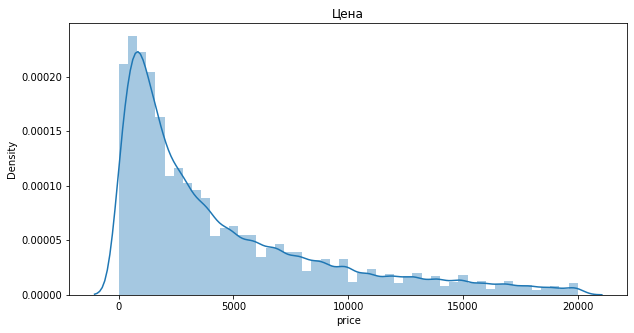

In [7]:
# Распределение целевого признака
plt.figure(figsize=(10,5))
plt.title('Цена')
sns.distplot(df['price'])

In [8]:
(df.isnull().sum())

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

При первом взгляде на датасет заметно, что в нем есть пропуски, а также много ненужных столбцов, например:

datecreated — дата скачивания анкеты из базы

registrationyear — месяц регистрации автомобиля

datecreated — дата создания анкеты

numberofpictures — количество фотографий автомобиля

postalcode — почтовый индекс владельца анкеты (пользователя)

lastseen — дата последней активности пользователя



In [9]:
display(df.describe(include=['object', 'bool']))

,datecrawled,vehicletype,gearbox,model,fueltype,brand,notrepaired,datecreated,lastseen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [10]:
display(df.describe())

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
df = df.drop(['datecrawled', 'registrationmonth', 'datecreated', \
              'numberofpictures', 'postalcode', 'lastseen'], axis='columns')

Посмотрим на выбросы

<AxesSubplot:>

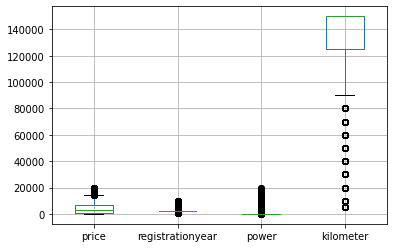

In [12]:
df.boxplot()

Пробег и цена могут быть какими угодно, а мощность и год регистрации нужно рассмотреть повнимательнее.

In [13]:
#уберем выбросы
#наиболее ранняя дата регистрации автомолбилей - это 1932 год. Пусть это будет нижней границей, а максимальную мощность 
#возьмём  за 350л/с
df = df.query('registrationyear <= 2022 and registrationyear >= 1932 and 50 <= power <= 500')
            


In [14]:
df.shape

(307702, 10)

<AxesSubplot:>

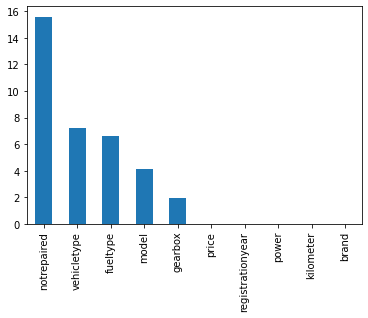

In [15]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

Пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. Заменим NaN-ы нетипичным значением unk - модель воспримет их как отдельную категорию.

20% в столбце NotRepaired. Скорее всего владельцы пропустили это значения потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке

10% в столбце VehicleType

9% в столбце FuelType

5% в столбце GearBox

5% в столбце Model

In [16]:
df.fillna(value='unk', inplace=True)
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,unk,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [17]:
#Убрали дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(10,5))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=5)
    plt.ylabel('Средняя цена ', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

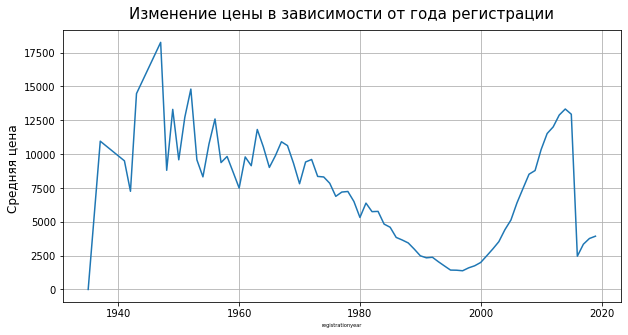

In [19]:
make_price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

Резкое падение цены с 2016 года.

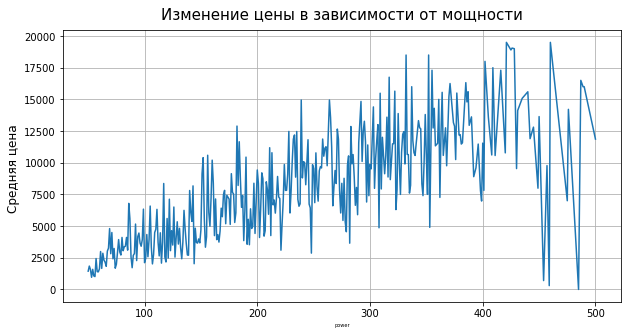

In [20]:
make_price_plot('power', 'Изменение цены в зависимости от мощности')

Цена растет вместе с мощностью.

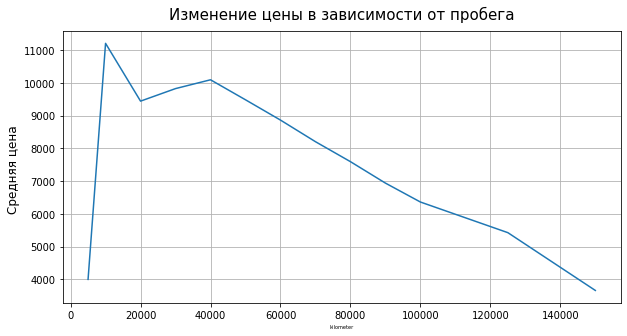

In [21]:
make_price_plot('kilometer', 'Изменение цены в зависимости от пробега')

Чем больше пробег, тем ниже цена. Всё логично.

In [22]:
def make_plotbar(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

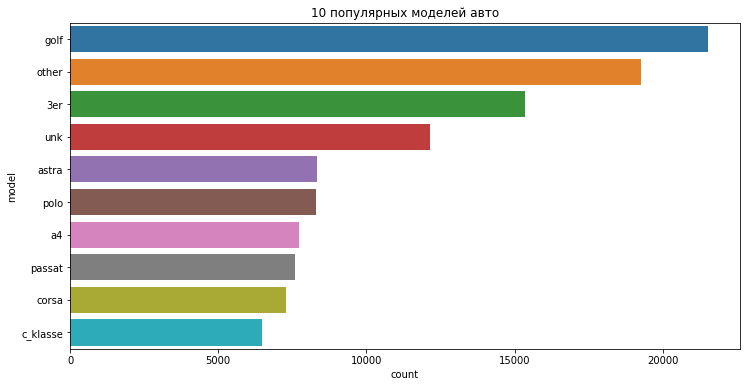

In [23]:
make_plotbar('model', '10 популярных моделей авто')

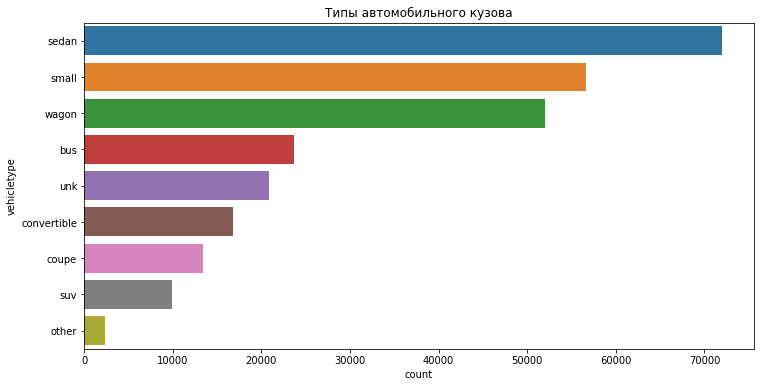

In [24]:
make_plotbar('vehicletype', 'Типы автомобильного кузова')

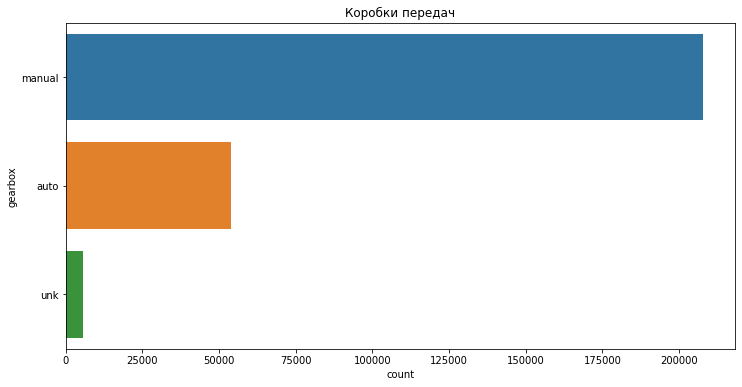

In [25]:
make_plotbar('gearbox', 'Коробки передач')

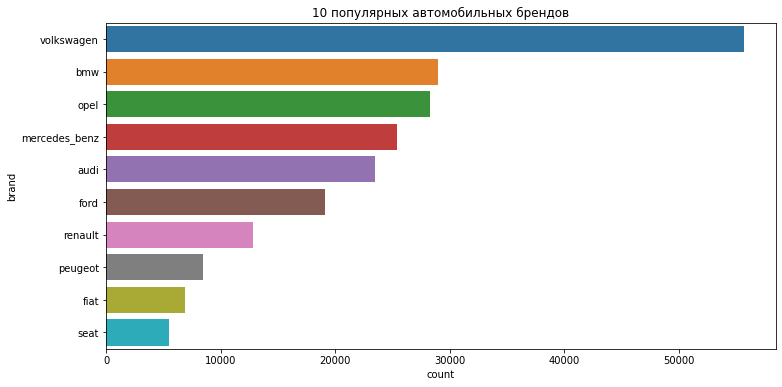

In [26]:
make_plotbar('brand', '10 популярных автомобильных брендов')

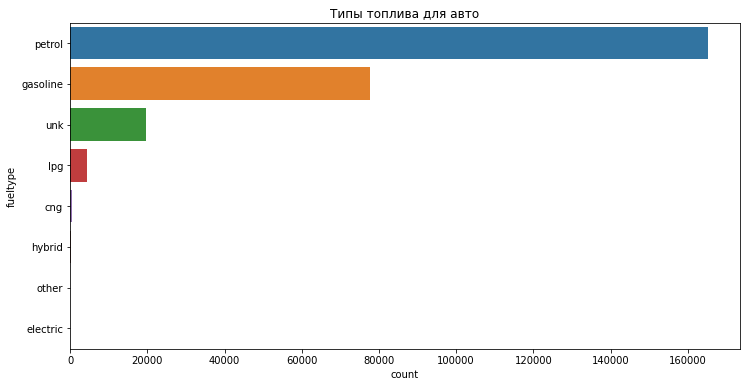

In [27]:
make_plotbar('fueltype', 'Типы топлива для авто')

#### Вывод
354365 строк и 16 столбцов

Присутствуют пропуски. Заменены не типичным значением.

Средняя стоимость авто 2700 евро

Минимальный год регистриции автомобиля 1000, максимальный - 9999 - Год регистрации ограничен рамками 1932-2022.

Макс.значение в мощности автомобиля в лошадинных силах = 20 000. Показатель не реальный.Мощность ограничена 350л/с.

Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Возможно просто ограничение ввода данных на сайте

Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12

Столбец с фото автомобилей. У нас их нет

8 уникальных типов автомобильного кузова

Чаще встречаются авто с ручной коробкой передач

Чаще встречаются автомобиле на бензине

Самый популярный бренд авто Volkswagen

Много пропусков в столбце о ремонте авто, но чаще встречаются автомобили без ремонта

В датасете присутствуют неинформативные признаки. Не нужные столбцы удалены.

In [28]:
cars_for_free = df.query('price == 0')
cars_for_free.shape

(5652, 10)

In [29]:
df = df.query('price != 0')

## Обучение моделей

In [30]:
df_ohe = pd.get_dummies(df, drop_first=True) 

In [31]:
#признаки для обучения модели линейной регрессии
features_lr = df_ohe.drop(['price'], axis = 1)
target_lr = df_ohe['price']

features_train_lr, features_test_lr, target_train_lr, target_test_lr = \
train_test_split(features_lr,target_lr, test_size=.25, random_state=12345)

In [32]:
categorical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [33]:
for col in categorical:
    df[col] = df[col].astype('category')

In [34]:
#признаки для обучения моделей CBR и LGBM
features = df.drop(['price'], axis = 1)
target = df['price']


In [35]:
# Получение пропорции 60:40

features_train, features_40, target_train, target_40 = train_test_split(
    features, target, test_size = 0.40, random_state = 12345)
# Разделение 40 % на две части

features_valid, features_test, target_valid, target_test = train_test_split(
    features_40, target_40, test_size = 0.50, random_state = 12345)

In [36]:
numeric = (
    ['registrationyear', 'power', 'kilometer']
)
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

/tmp/ipykernel_115/3616344165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_115/3616344165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [37]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse
          

In [38]:
#LinearRegression
lr_model = LinearRegression()


In [39]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

CPU times: user 22.6 s, sys: 21.4 s, total: 44 s
Wall time: 44.5 s


LinearRegression()

In [40]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_test_lr))

CPU times: user 86.5 ms, sys: 134 ms, total: 220 ms
Wall time: 263 ms


In [41]:
rmse(target_test_lr, predicted_lr)

2634.8890741972427

In [42]:
#CatBoostRegressor
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations 
#с помощью кросс-валидации
for iteration in range(10, 111, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10,\
                                  verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()


Learning rate set to 0.5
0:	learn: 3167.3242160	total: 144ms	remaining: 1.3s
9:	learn: 1782.9147602	total: 684ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3175.5207018	total: 59.4ms	remaining: 535ms
9:	learn: 1790.2088563	total: 527ms	remaining: 0us
Score при iterations = 10 : [0.84171117 0.84316937]
Score mean = 0.8424402687419308

Learning rate set to 0.5
0:	learn: 3167.3242160	total: 53.2ms	remaining: 1.81s
10:	learn: 1758.6207855	total: 570ms	remaining: 1.24s
20:	learn: 1669.1196133	total: 1.13s	remaining: 750ms
30:	learn: 1607.8546216	total: 1.67s	remaining: 216ms
34:	learn: 1592.5245016	total: 1.88s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3175.5207018	total: 57.1ms	remaining: 1.94s
10:	learn: 1779.1363155	total: 644ms	remaining: 1.41s
20:	learn: 1681.2138229	total: 1.22s	remaining: 816ms
30:	learn: 1623.2306542	total: 1.82s	remaining: 235ms
34:	learn: 1601.6950454	total: 2.02s	remaining: 0us
Score при iterations = 35 : [0.85770469 0.85825534]
Score mean = 0.8579

In [43]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth,\
                                  verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.5
0:	learn: 3423.5362483	total: 51.2ms	remaining: 973ms
10:	learn: 1995.1581444	total: 398ms	remaining: 325ms
19:	learn: 1897.3713421	total: 716ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3440.1486214	total: 50.8ms	remaining: 964ms
10:	learn: 2005.2909564	total: 419ms	remaining: 343ms
19:	learn: 1905.3648064	total: 721ms	remaining: 0us
Score при depth = 5 : [0.82958567 0.83156436]
Score mean = 0.8305750127546687

Learning rate set to 0.5
0:	learn: 3251.9350334	total: 37.6ms	remaining: 715ms
10:	learn: 1885.1486910	total: 394ms	remaining: 322ms
19:	learn: 1805.2270479	total: 714ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3281.5071059	total: 47.6ms	remaining: 905ms
10:	learn: 1896.0429366	total: 514ms	remaining: 421ms
19:	learn: 1813.7586776	total: 991ms	remaining: 0us
Score при depth = 7 : [0.8425688  0.84403068]
Score mean = 0.8432997362884646

Learning rate set to 0.5
0:	learn: 3175.1290281	total: 102ms	remaining: 1.94s
10:	learn: 1787.3059921	

Можно отметить, что при увеличении iterations модель сначала дает бОльшую точность , затем увеличение точности начинает снижаться, до тех пор, пока разница не становится незначительной. Нужно помнить, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому не будем жертвовать скоростью и выберем оптимальный вариант с числом iterations 90.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 13.

Измерим время обучения и работы модели со значением iterations = 90 и depth = 11.

In [44]:
cat_model_90_11= CatBoostRegressor(loss_function="RMSE", iterations=90, depth=11, verbose=10)

In [45]:
%%time
cat_model_90_11.fit(features_train, target_train, cat_features=categorical)

Learning rate set to 0.5
0:	learn: 3144.5777862	total: 141ms	remaining: 12.5s
10:	learn: 1745.7805423	total: 1.37s	remaining: 9.86s
20:	learn: 1652.4894430	total: 2.74s	remaining: 9s
30:	learn: 1596.1142146	total: 4.06s	remaining: 7.73s
40:	learn: 1551.7274484	total: 5.4s	remaining: 6.45s
50:	learn: 1513.3642935	total: 6.64s	remaining: 5.08s
60:	learn: 1490.4713698	total: 8s	remaining: 3.8s
70:	learn: 1465.1141726	total: 9.31s	remaining: 2.49s
80:	learn: 1450.7934884	total: 10.6s	remaining: 1.18s
89:	learn: 1434.4189582	total: 11.8s	remaining: 0us
CPU times: user 11.8 s, sys: 131 ms, total: 12 s
Wall time: 12.4 s


In [46]:
%%time
predicted_cat_90_11 = pd.Series(cat_model_90_11.predict(features_test))

CPU times: user 93.1 ms, sys: 0 ns, total: 93.1 ms
Wall time: 95 ms


In [47]:
rmse(target_test, predicted_cat_90_11)

1659.2009925001914

In [48]:
#LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [49]:
lgbm_model = LGBMRegressor(**params)

In [50]:
%%time
lgbm_model.fit(features_train, target_train)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.309406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 4min 36s, sys: 3.25 s, total: 4min 39s
Wall time: 4min 42s


LGBMRegressor(max_depth=6, metric='rmse', objective='regression', silent=True,
              verbose=0)

In [51]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 580 ms


In [52]:
rmse(target_test, predictions_lgbm)

1663.6159831686948

## Анализ моделей

In [53]:
#финальное тестирование лучшей модели с подобранными гиперпараметрамми
cat_model_90_11= CatBoostRegressor(loss_function="RMSE", iterations=90, depth=11, verbose=10)

In [54]:
%%time
cat_model_90_11.fit(features_train, target_train, cat_features=categorical)

Learning rate set to 0.5
0:	learn: 3144.5777862	total: 126ms	remaining: 11.2s
10:	learn: 1745.7805423	total: 1.31s	remaining: 9.38s
20:	learn: 1652.4894430	total: 2.53s	remaining: 8.32s
30:	learn: 1596.1142146	total: 3.67s	remaining: 6.99s
40:	learn: 1551.7274484	total: 4.86s	remaining: 5.81s
50:	learn: 1513.3642935	total: 6.05s	remaining: 4.63s
60:	learn: 1490.4713698	total: 7.35s	remaining: 3.49s
70:	learn: 1465.1141726	total: 8.53s	remaining: 2.28s
80:	learn: 1450.7934884	total: 9.67s	remaining: 1.07s
89:	learn: 1434.4189582	total: 10.7s	remaining: 0us
CPU times: user 10.8 s, sys: 142 ms, total: 10.9 s
Wall time: 11.4 s


In [55]:
%%time
predicted_cat_90_11 = pd.Series(cat_model_90_11.predict(features_valid))

CPU times: user 67.4 ms, sys: 0 ns, total: 67.4 ms
Wall time: 65.5 ms


In [56]:
rmse(target_valid, predicted_cat_90_11)

1671.135770919882

In [57]:

models = [['LR', 16.5, 154, 2634.8], ['CBR', 11.3, 53.3, 1659.2], 
       ['LGB', 3.69, 463, 1663],['Final_test', 10.2, 54.4, 1671.13]] 
    
df = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
df 


,model,"train_time, sec","work_time, msec",rmse
0,LR,16.50,154.0,2634.80
1,CBR,11.30,53.3,1659.20
2,LGB,3.69,463.0,1663.00
3,Final_test,10.20,54.4,1671.13


###  Вывод
Время предсказания любой модели значительно меньше, чем её обучение. Важно, чтобы время предсказания было как можно меньше.

Метрика RMSE лучше всего выглядит у модели CBR. Время работы и обучения наименьшее у модели LGB. Так как в проекте значение имеют и скорость обучения и точность модели,ввиду того, что временная разница в обучении CBR и LGB не критичная - предпочтение я отдал модели CBR из-за лучшей точности.

 Худшие результаты как по времени обучения, так и по точности показала модель Линейной Регрессии.

 Модель CatBoostRegressor можно посоветовать сервису как прототип.